<p style="text-align: center;">SEAS 6414 - Python Applications in Data Analytics</p>
<p style="text-align: center;">Homework 8</p>
<p style="text-align: center;">Due Date: March 9, 2024 (10:00am EST)</p>

Instructions: To complete the following task using Python, please download an
Integrated Development Environment (IDE) of your choice. Ensure that your solution
includes both the written code (input) and its corresponding output. Once completed,
upload your solution in PDF format or any other format you prefer. The questions
are worth 50 points each.

# Note

I have left in some paths I took that did not pan out. Normally, I take them all out. For this last assignment, I left a few in.

All of the imports

In [111]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit  # you have everything done for you
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import logging
from prophet import Prophet
logging.getLogger().setLevel(logging.ERROR)

# 1 Data Preparation
- Analyze merchant transaction data from January 1, 2033, to January 1, 2035.
- Resample the data to obtain daily transaction sums (in Dollars).

In [112]:

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

HW8F1 = pd.read_csv('./homework8.csv')

In [113]:
HW8F1.shape

(1513719, 4)

In [114]:
HW8F1.head()

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203


In [115]:
HW8F1['merchant'].nunique()

14351

In [116]:
# Rename the unnamed column
HW8F1 = HW8F1.rename(columns={'Unnamed: 0': 'ID'})

In [117]:
# convert the cents to dollars
HW8F1 = HW8F1.rename(columns={'amount_usd_in_cents': 'amount_usd_in_dollars'})  # Rename the amount column
HW8F1 = HW8F1.assign(amount_usd_in_dollars=lambda x: x['amount_usd_in_dollars'] / 100)  # Convert cents to dollars

In [118]:
#transform to datetime format
HW8F1['time'] = pd.to_datetime(HW8F1['time'])

In [119]:
HW8F1.head()

,ID,merchant,time,amount_usd_in_dollars
0,1,faa029c6b0,2034-06-17 23:34:14,63.49
1,2,ed7a7d91aa,2034-12-27 00:40:38,38.54
2,3,5608f200cf,2034-04-30 01:29:42,7.89
3,4,15b1a0d61e,2034-09-16 01:06:23,44.52
4,5,4770051790,2034-07-22 16:21:42,202.03


In [120]:
HW8F1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   ID                     1513719 non-null  int64         
 1   merchant               1513719 non-null  object        
 2   time                   1513719 non-null  datetime64[ns]
 3   amount_usd_in_dollars  1513719 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 46.2+ MB


In [121]:
# Resample by merchant, day on 'time' / Sum the amount_usd_in_cents for each group / Reset index to create separate columns
daily_sales1 = HW8F1.groupby('merchant').resample('D', on='time',include_groups=False).sum().reindex().drop(columns=['ID'])

In [122]:
daily_sales1.shape

(2883395, 1)

In [123]:
daily_sales1.head()

amount_usd_in_dollars
merchant   time                             
0002b63b92 2033-05-16                  33.79
0002d07bba 2034-10-11                  55.49
           2034-10-12                   0.00
           2034-10-13                   0.00
           2034-10-14                   0.00

At first it seemed to me that I should group by merchant. But I realized that this would create too many rows and was not the goal. It is the total sales per day irrespective of the merchant. Grouping by merchant is not called for here. So, I will create a new dataframe without it.

In [124]:
# Resample by day on 'time' / Sum the amount_usd_in_cents for each group / Reset index to create separate columns
daily_sales2 = HW8F1.resample('D', on='time').sum().reindex().drop(columns=['ID','merchant'])

In [125]:
daily_sales2.shape

(730, 1)

In [126]:
daily_sales2.head()

,amount_usd_in_dollars
time,
2033-01-01,"4,415.40"
2033-01-02,"4,758.62"
2033-01-03,"6,283.53"
2033-01-04,"4,851.11"
2033-01-05,"10,016.21"


In [127]:
daily_sales2.describe()

,amount_usd_in_dollars
count,730.00
mean,"321,088.02"
std,"247,370.12"
min,"4,415.40"
25%,"134,365.02"
50%,"284,525.09"
75%,"473,967.63"
max,"2,663,536.30"


Lets look at the data to see what we have.

In [128]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

A seven day moving average.

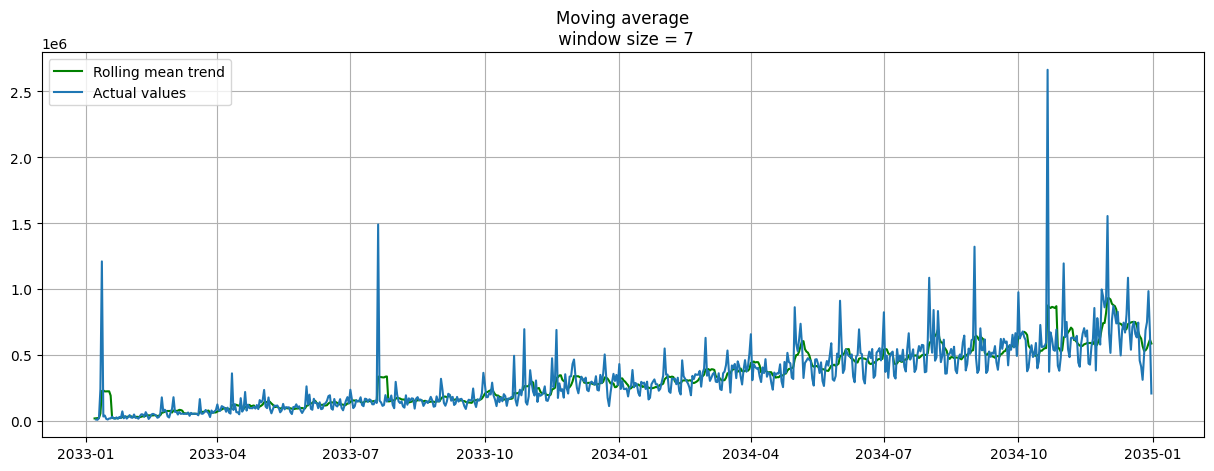

In [129]:
plotMovingAverage(daily_sales2,7)

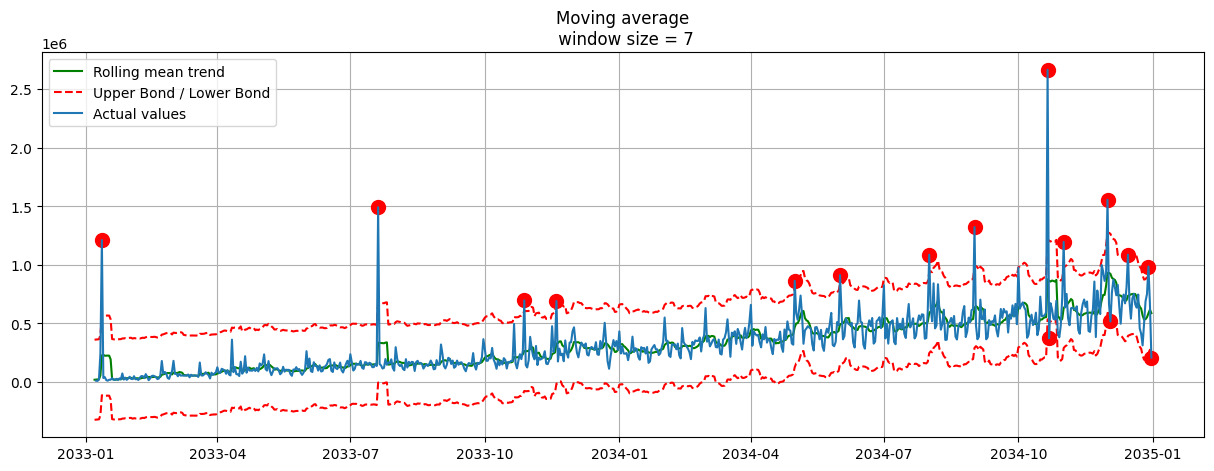

In [130]:
plotMovingAverage(
    daily_sales2, 7, plot_intervals=True, plot_anomalies=True
)  # weekly smoothing

It looks like there are a few outliers. I count 16, three of which seem extreme. Let's do a simple process to remove them.

In [131]:
daily_sales3 = daily_sales2[np.abs(stats.zscore(daily_sales2['amount_usd_in_dollars'])) < 3]

In [132]:
daily_sales3.shape

(722, 1)

Went from 730 down to 722 so we removed 8 outliers. Lets see the result.

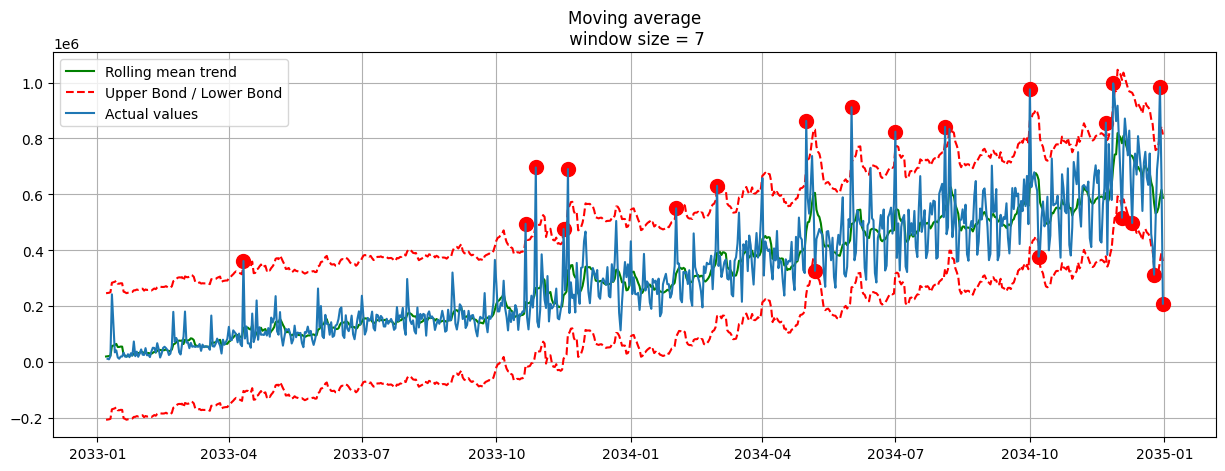

In [133]:
plotMovingAverage(
    daily_sales3, 7, plot_intervals=True, plot_anomalies=True
)  # weekly smoothing

It went from 16 outliers to 21. But these are less severe. I am not sure that it is better.

This looks better. So, here is what I have:

- daily_sales1 - the data grouped by merchant and summed by day. Not really useful.
- daily_sales2 - the data summed by day.
- daily_sales3 - the data summed by day and removal of outliers based on z score.

After reviewing the graphs, I am not sure I can tell what to use for seasonality. My best guess is weekly or seven days. I am going to leave the outliers in for this. So, going forward I will be using daily_sales2.

I also note that the data is not stationary. There is a clear trend upwards. I think that the SARIMA section addressed this. Since our homework doe not require SARIMA, I will not address it.

# 2 Forecasting Methods

## 2.1 Holt-Winters (Triple Exponential Smoothing)
Apply Holt-Winters method to capture seasonality, trend, and level in the daily transaction data.

In [134]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [135]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [136]:
%%time
data = daily_sales2.amount_usd_in_dollars[:-20]  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_error), # changed from log because it complained about negative values
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    data,
    slen=7,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3,
)
model.triple_exponential_smoothing()

0.010009174709418145 0.024494780538362126 0.08887341741955923
CPU times: total: 1.34 s
Wall time: 1.96 s


In [137]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """

    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(series.values, model.result[: len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[: len(series)]] = series.values[
            series.values < model.LowerBond[: len(series)]
        ]
        anomalies[series.values > model.UpperBond[: len(series)]] = series.values[
            series.values > model.UpperBond[: len(series)]
        ]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(
            x=range(0, len(model.result)),
            y1=model.UpperBond,
            y2=model.LowerBond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        len(series),
        ymin=min(model.LowerBond),
        ymax=max(model.UpperBond),
        linestyles="dashed",
    )
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

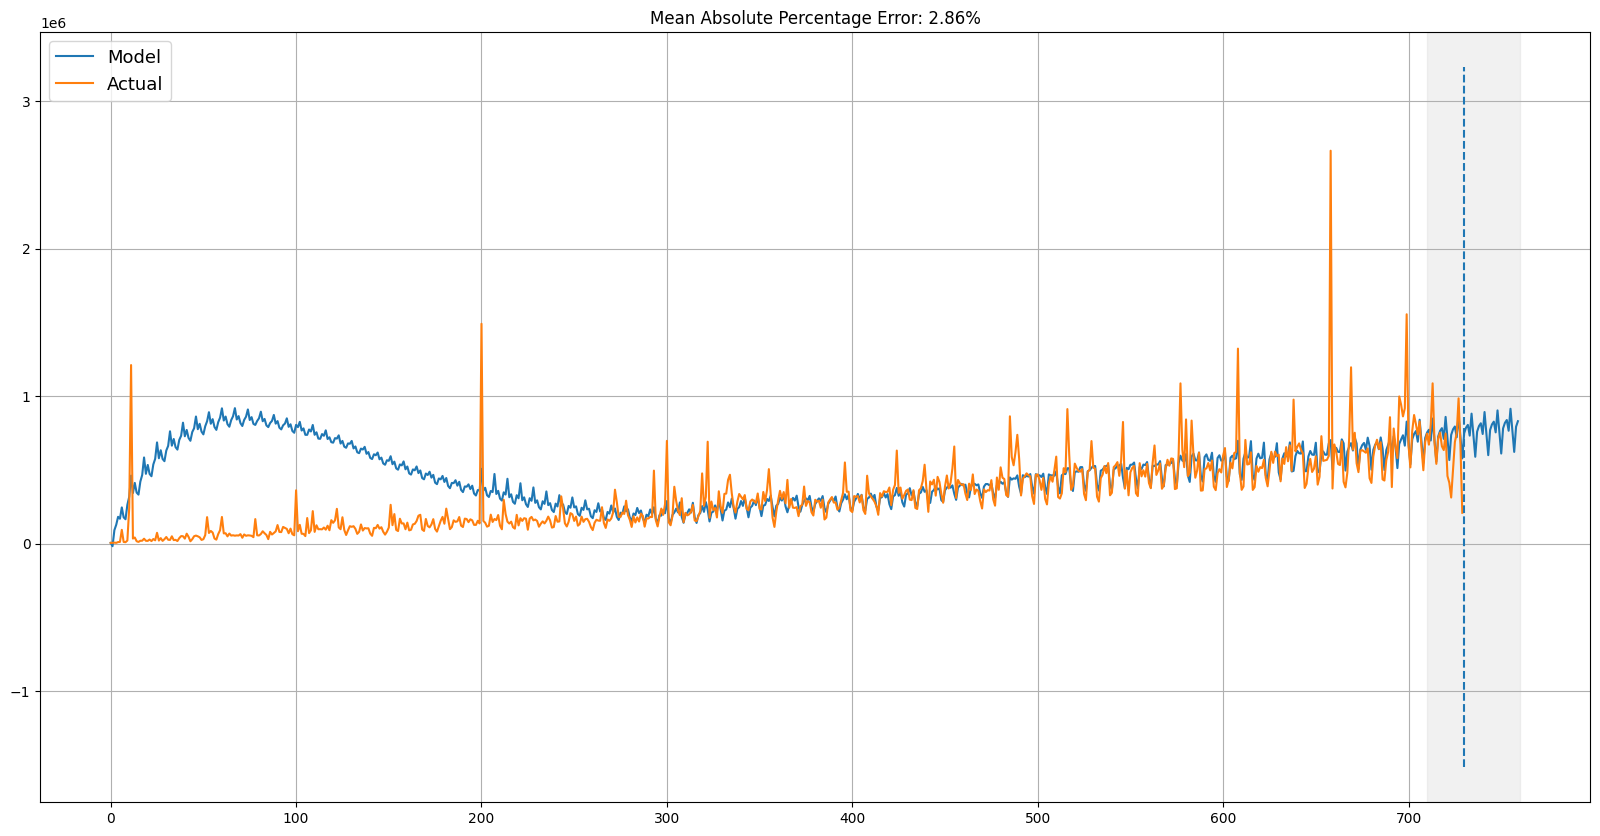

In [138]:
plotHoltWinters(daily_sales2.amount_usd_in_dollars)

It starts off bad but then settles into a nice pattern that follows the actual data less some of the extremes. Are the extremes noise or should we be trying to map to them? I am not sure.

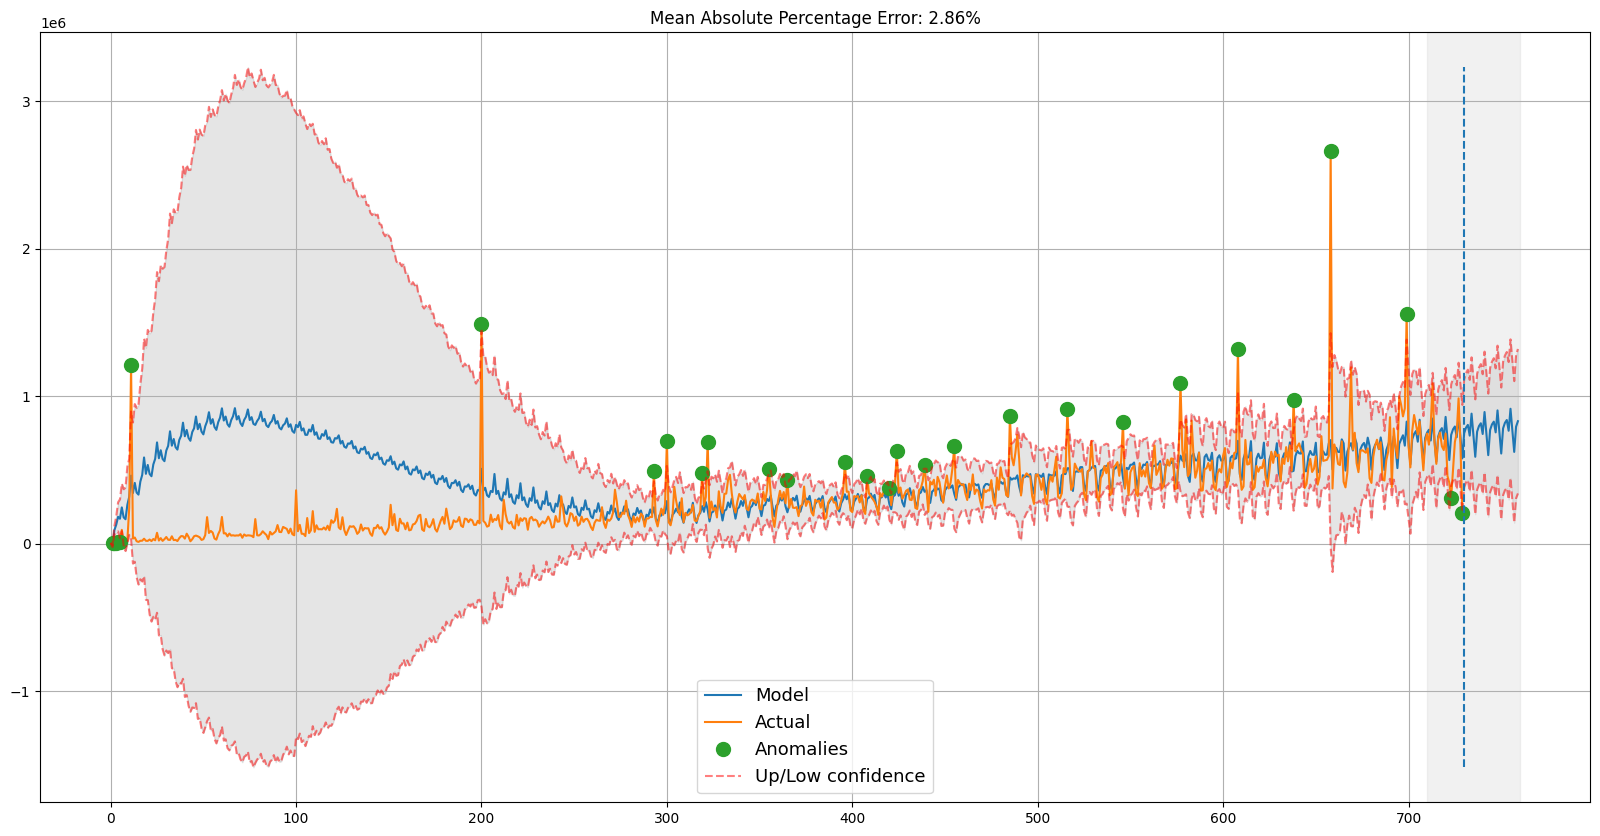

In [139]:
plotHoltWinters(daily_sales2.amount_usd_in_dollars, plot_intervals=True, plot_anomalies=True)

Still a lot of values outside the confidence interval.

## 2.2 Time Series Cross-Validation
Use time series cross-validation for evaluating the performance of the models.

In [140]:
# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

## 2.3 Feature Engineering with Lags
Create new features based on lagged values of the time series for linear regression and random forest models.

In [141]:
# Creating a copy of the initial dataframe to make various transformations
data = pd.DataFrame(daily_sales2.amount_usd_in_dollars.copy())
data.columns = ["y"]

In [142]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [143]:
# take a look at the new dataframe
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
time,,,,,,,,,,,,,,,,,,,,
2034-12-25,"312,083.41","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37","871,449.25","764,173.63","516,244.61","665,798.12","1,554,456.47"
2034-12-26,"499,564.87","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37","871,449.25","764,173.63","516,244.61","665,798.12"
2034-12-27,"688,573.47","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37","871,449.25","764,173.63","516,244.61"
2034-12-28,"750,020.80","746,183.26","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37","871,449.25","764,173.63"
2034-12-29,"984,672.08","457,942.73","746,183.26","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37","871,449.25"
2034-12-30,"668,559.95","412,629.69","457,942.73","746,183.26","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37"
2034-12-31,"208,533.08","312,083.41","412,629.69","457,942.73","746,183.26","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85"


## 2.4 Linear Regression Model
Implement a linear regression model using the lagged features.

In [144]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [145]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [146]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Calculate and store the MAPE for LR.

In [147]:
MAPE_LR = mean_absolute_percentage_error(lr.predict(X_test), y_test)
MAPE_LR

0.20939886824567627

In [148]:
def plotModelResults(
    model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed");

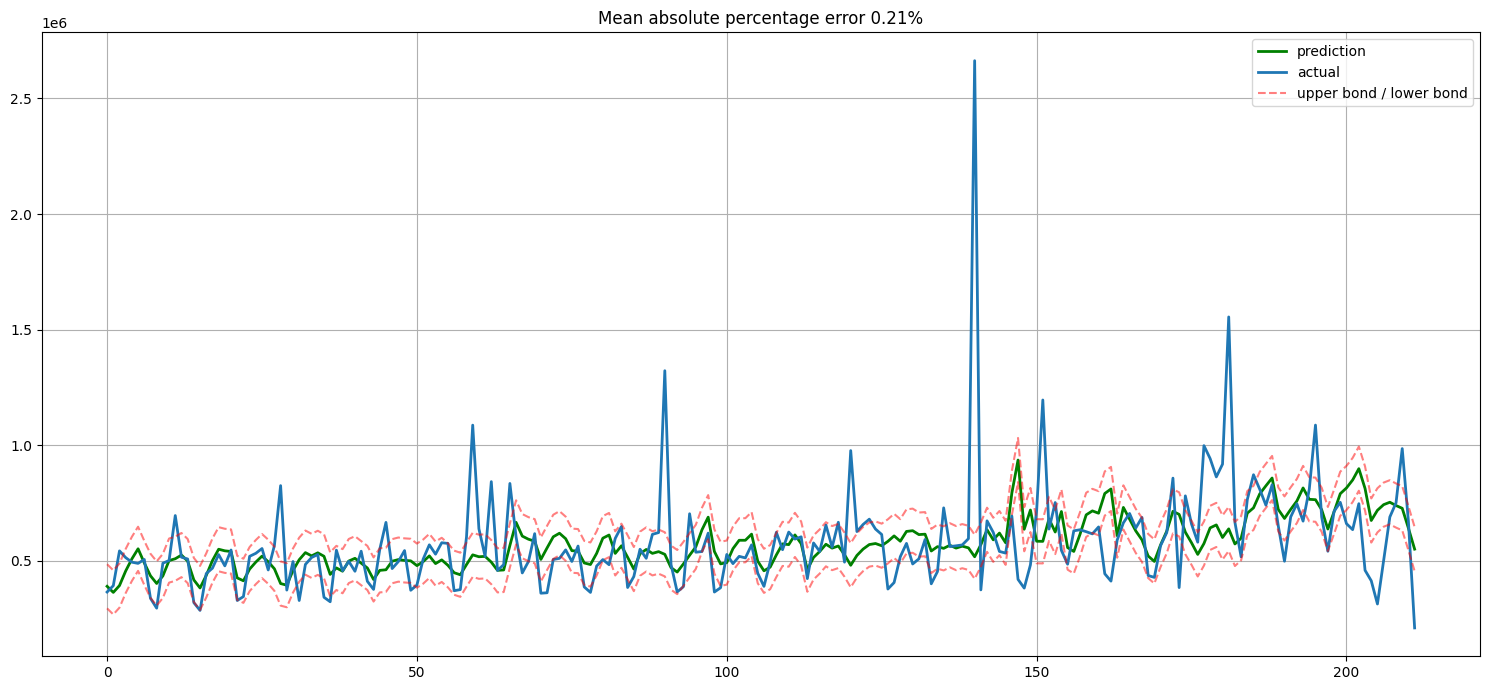

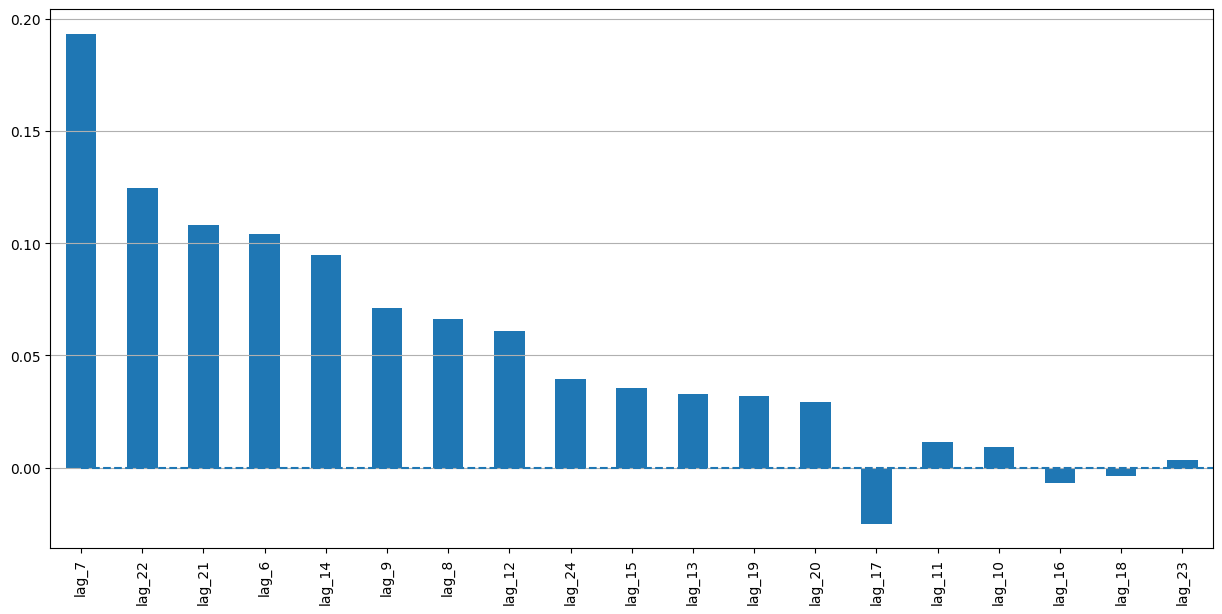

In [149]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Add Weekday and Weekend to see if they can help the model.

In [150]:
data_plus_time = data.copy(deep=True)
data_plus_time.index = pd.to_datetime(data.index)
data_plus_time["weekday"] = data_plus_time.index.weekday
data_plus_time["is_weekend"] = data_plus_time.weekday.isin([5, 6]) * 1
data_plus_time.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,weekday,is_weekend
time,,,,,,,,,,,,,,,,,,,,,,
2034-12-27,"688,573.47","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37","871,449.25","764,173.63","516,244.61",2,0
2034-12-28,"750,020.80","746,183.26","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37","871,449.25","764,173.63",3,0
2034-12-29,"984,672.08","457,942.73","746,183.26","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37","871,449.25",4,0
2034-12-30,"668,559.95","412,629.69","457,942.73","746,183.26","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85","809,039.37",5,1
2034-12-31,"208,533.08","312,083.41","412,629.69","457,942.73","746,183.26","633,820.61","659,891.45","752,171.23","712,842.49","540,359.50","688,965.40","1,086,375.85","808,416.72","670,715.73","745,896.88","688,829.95","497,127.73","649,725.58","828,092.79","739,696.85",6,1


In [151]:
scaler = StandardScaler()

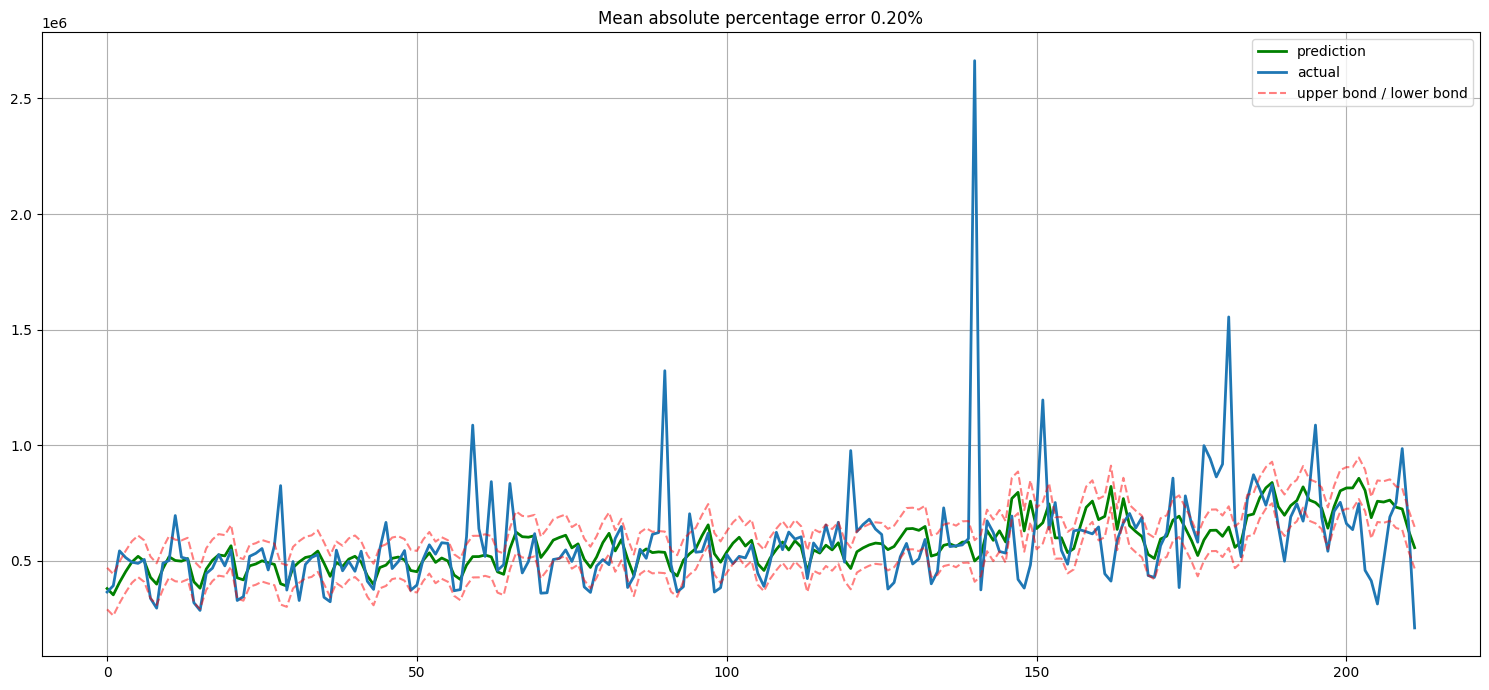

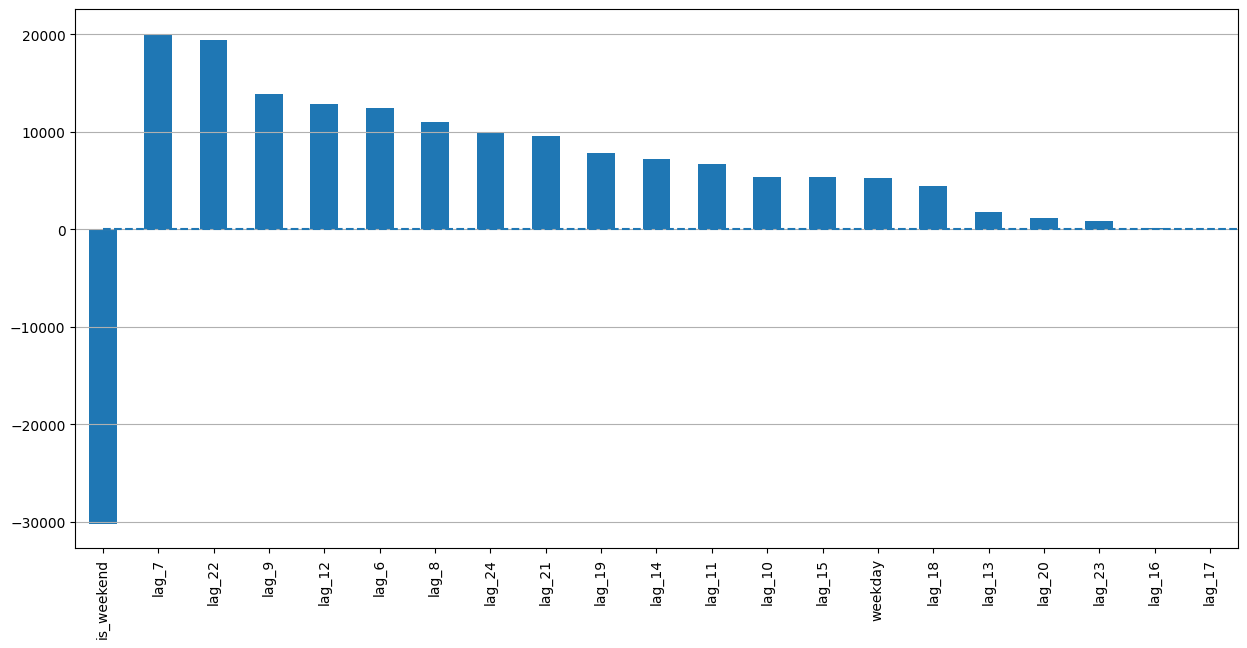

In [152]:
y = data_plus_time.dropna().y
X = data_plus_time.dropna().drop(["y"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Calculate and store the MAPE for Linear Regression with Weekend and Weekday.

In [153]:
MAPE_LRS = mean_absolute_percentage_error(lr.predict(X_test_scaled), y_test)
MAPE_LRS

0.20237243649488235

My interpretation of this is that it is not on a weekend and follows a week / month cycle.

## 2.5 Random Forest Model
Similarly, use the lagged features in a random forest model for forecasting.

In [154]:
# Start fresh with the variables
del y, X, X_train, X_test, y_train, y_test

In [155]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [156]:
X_train.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
time,,,,,,,,,,,,,,,,,,,
2033-01-25,"32,943.04","19,194.69","18,953.62","11,087.61","15,817.95","41,119.03","34,005.18","1,210,293.14","241,898.77","20,481.44","9,100.92","10,977.77","92,925.77","11,055.98","10,016.21","4,851.11","6,283.53","4,758.62","4,415.40"
2033-01-26,"18,733.76","32,943.04","19,194.69","18,953.62","11,087.61","15,817.95","41,119.03","34,005.18","1,210,293.14","241,898.77","20,481.44","9,100.92","10,977.77","92,925.77","11,055.98","10,016.21","4,851.11","6,283.53","4,758.62"
2033-01-27,"18,221.52","18,733.76","32,943.04","19,194.69","18,953.62","11,087.61","15,817.95","41,119.03","34,005.18","1,210,293.14","241,898.77","20,481.44","9,100.92","10,977.77","92,925.77","11,055.98","10,016.21","4,851.11","6,283.53"
2033-01-28,"27,234.13","18,221.52","18,733.76","32,943.04","19,194.69","18,953.62","11,087.61","15,817.95","41,119.03","34,005.18","1,210,293.14","241,898.77","20,481.44","9,100.92","10,977.77","92,925.77","11,055.98","10,016.21","4,851.11"
2033-01-29,"16,732.76","27,234.13","18,221.52","18,733.76","32,943.04","19,194.69","18,953.62","11,087.61","15,817.95","41,119.03","34,005.18","1,210,293.14","241,898.77","20,481.44","9,100.92","10,977.77","92,925.77","11,055.98","10,016.21"


In [157]:
param_grid = {'n_estimators': [1, 10, 50, 100, 200, 300, 400]}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=7)
grid.fit(X_train, y_train)
grid.best_params_

{'n_estimators': 300}

Every time I run this, I get a different answer. I have received 300, 400, 1, and 50 as answers.

In [158]:
rf = RandomForestRegressor(grid.best_params_['n_estimators'])
rf.fit(X_train, y_train)
y_train = rf.predict(X_train)
y_test = rf.predict(X_test)

In [159]:
MAPE_RF = mean_absolute_percentage_error(rf.predict(X_test), y_test)
MAPE_RF

0.0

In [160]:
print(y_test)

[360710.97056667 329906.91576667 389267.4182     441838.11043333
 462648.60953333 576401.827      534723.3076     384603.0315
 345696.46436667 454437.78076667 436182.7887     453565.94523333
 495555.75436667 494620.05276667 398136.13186667 336784.75106667
 416465.1274     470279.22683333 470092.15136667 497688.92373333
 521893.40056667 421958.27793333 395064.02456667 479311.21586667
 467368.28083333 478796.27       550493.19906667 545934.4079
 380182.07206667 349197.23113333 454370.1333     461884.6262
 463753.18603333 553133.67696667 557051.0085     411117.00483333
 363983.66503333 471885.31006667 435520.96683333 466506.01456667
 512428.94793333 499474.33076667 383195.7611     404278.3333
 466492.2067     447339.36786667 474750.2375     504377.55076667
 524257.27506667 475711.17553333 466075.33496667 495447.96153333
 444945.22693333 453384.9558     499248.8398     470769.43253333
 412640.47613333 402928.50486667 466809.78953333 457777.88446667
 479460.9934     523466.72263333 476277.0

Something is wrong with the type and I ran out of time to figure out how to fix it. I am sure it is a simple fix.

AttributeError: 'numpy.ndarray' object has no attribute 'values'

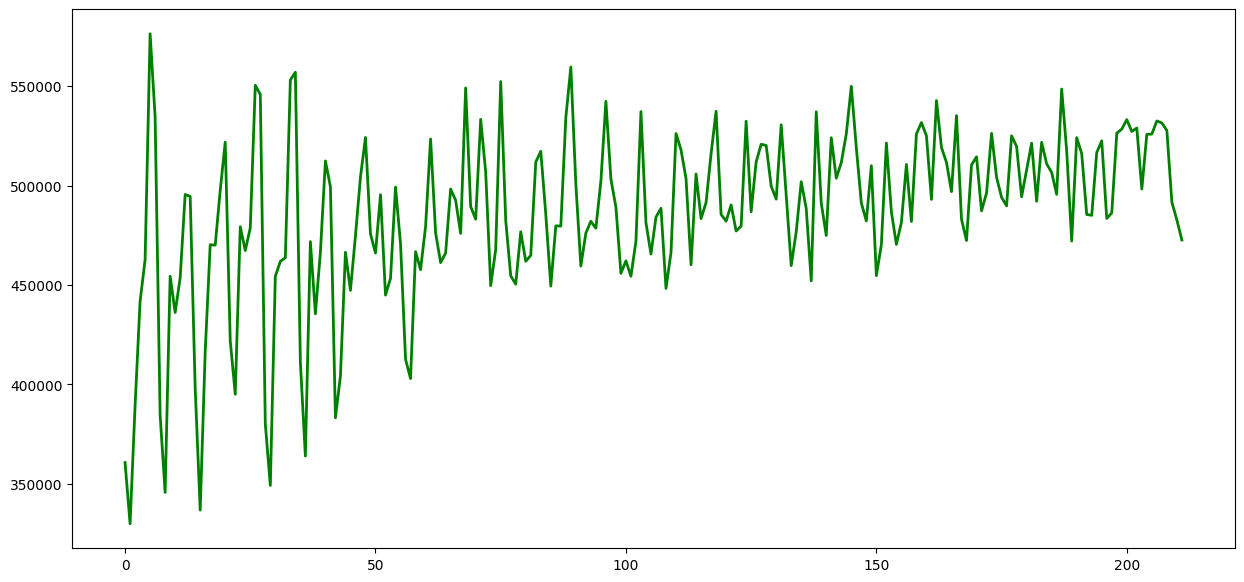

In [161]:
plotModelResults(rf, plot_intervals=True)
plotCoefficients(rf)

## 2.6 Facebook Prophet
Implement the Facebook Prophet model for forecasting.

### Data

In [162]:
# Create a copy of te data and sort it
daily_sales4 = daily_sales2.copy(deep = True)
daily_sales4.sort_values(by=["time"]).head(n=3)

,amount_usd_in_dollars
time,
2033-01-01,"4,415.40"
2033-01-02,"4,758.62"
2033-01-03,"6,283.53"


### Exploratory visual analysis

Using plotly

In [163]:
# Initialize plotly
init_notebook_mode(connected=True)

In [164]:
def plotly_df(df, title=""):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode="lines")
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [165]:
plotly_df(daily_sales4, title="Merchant sales (daily)")

Going from daily to weekly.

In [166]:
weekly_sales1 = daily_sales4.resample("W").apply(sum)

In [167]:
plotly_df(weekly_sales1, title="Merchant sales (weekly)")

### Making a forecast

In [168]:
df = daily_sales4.reset_index()
df.columns = ["ds", "y"]
# converting timezones (issue https://github.com/facebook/prophet/issues/831)
# Caused an error, this data has not time, so there is no timezone.
# df["ds"] = df["ds"].dt.tz_convert(None)
df.tail(n=3)

,ds,y
727,2034-12-29,"984,672.08"
728,2034-12-30,"668,559.95"
729,2034-12-31,"208,533.08"


In [169]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
697,2034-11-29,"862,086.23"
698,2034-11-30,"917,309.40"
699,2034-12-01,"1,554,456.47"


In [170]:
m = Prophet()
m.fit(train_df)

21:14:15 - cmdstanpy - INFO - Chain [1] start processing


21:14:15 - cmdstanpy - INFO - Chain [1] done processing


In [171]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
727,2034-12-29
728,2034-12-30
729,2034-12-31


In [172]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
727,2034-12-29,"708,074.62","572,452.25","943,334.29","707,655.73","708,557.74","50,741.13","50,741.13","50,741.13","50,741.13","50,741.13","50,741.13",0.00,0.00,0.00,"758,815.75"
728,2034-12-30,"709,275.08","501,256.99","874,250.53","708,825.27","709,766.50","-36,958.02","-36,958.02","-36,958.02","-36,958.02","-36,958.02","-36,958.02",0.00,0.00,0.00,"672,317.07"
729,2034-12-31,"710,475.54","447,450.60","790,843.39","709,992.17","711,018.29","-83,405.13","-83,405.13","-83,405.13","-83,405.13","-83,405.13","-83,405.13",0.00,0.00,0.00,"627,070.41"


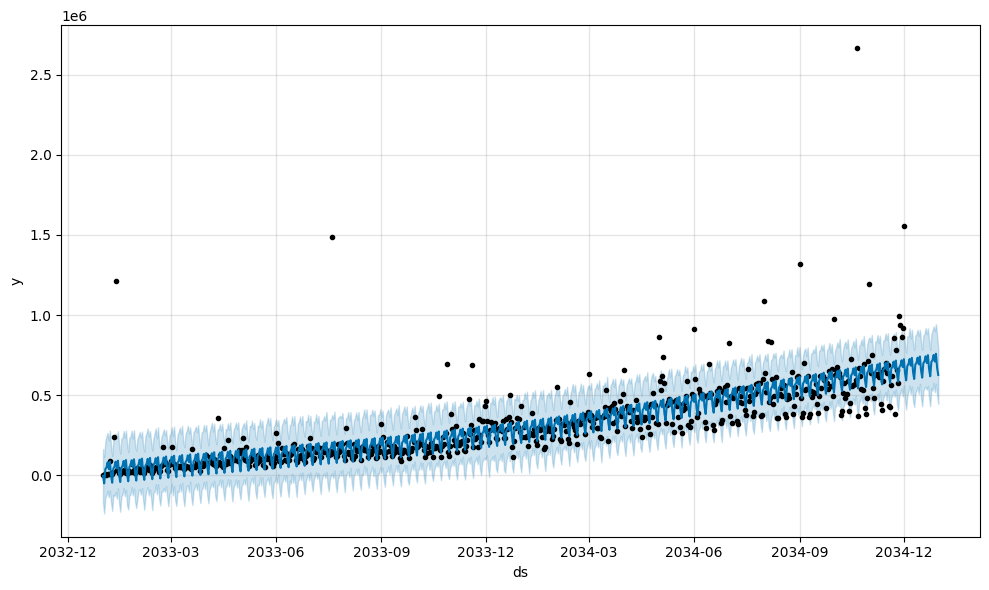

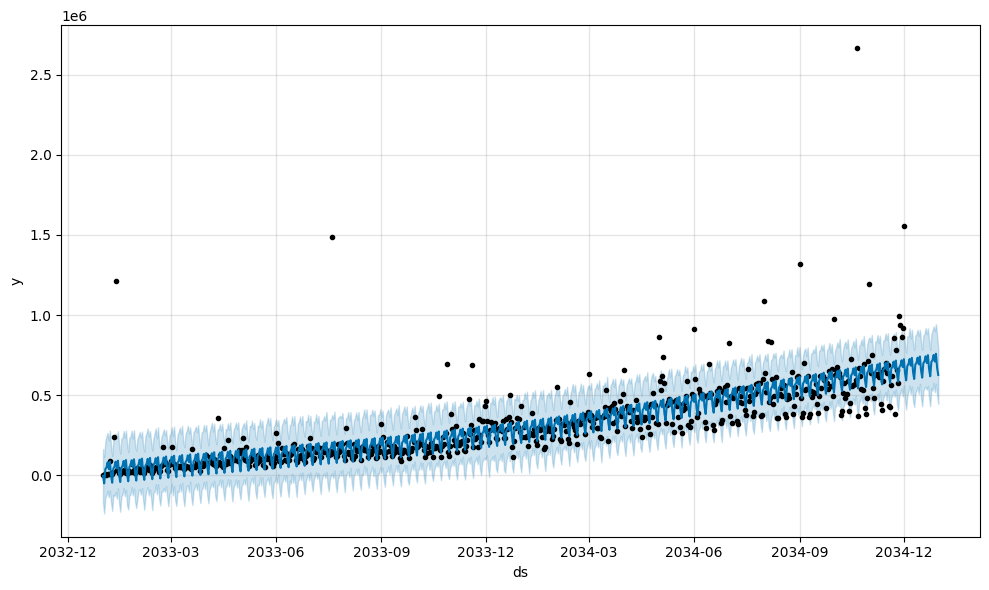

In [173]:
m.plot(forecast)

I am not sure why the graph is printing twice.

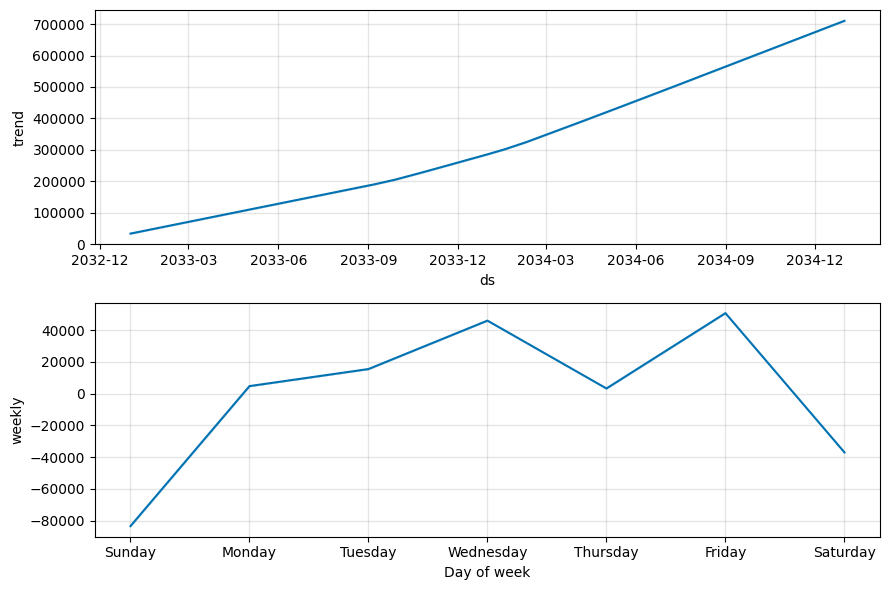

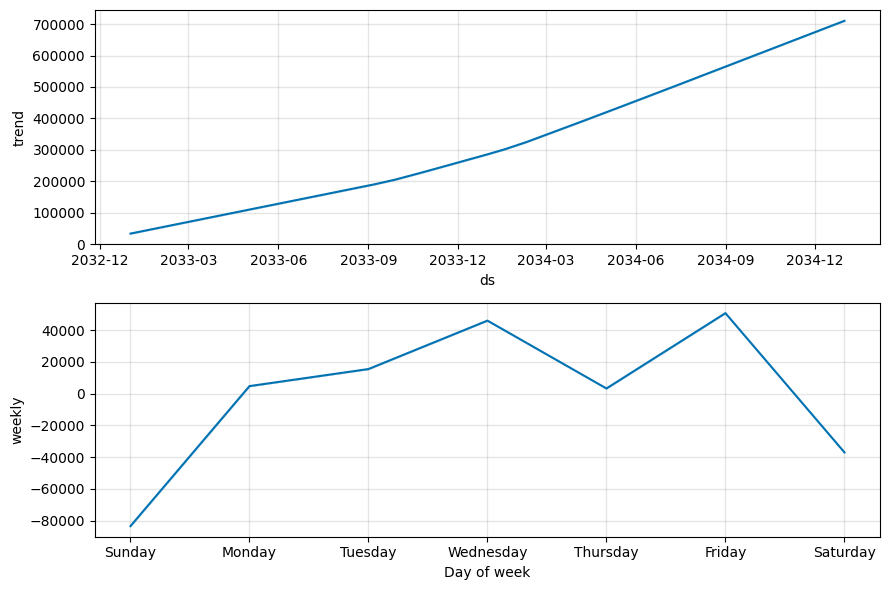

In [174]:
m.plot_components(forecast)

Again, the graphs are printing twice but there is no monthly plot.

### Forecast quality evaluation

In [175]:
print(", ".join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [176]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds")
    )

In [177]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2034-12-29,"758,815.75","572,452.25","943,334.29","984,672.08"
2034-12-30,"672,317.07","501,256.99","874,250.53","668,559.95"
2034-12-31,"627,070.41","447,450.60","790,843.39","208,533.08"


In [178]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """

    # Make a copy
    df = df.copy()

    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]

    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model.

    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {"MAPE": error_mean("p"), "MAE": error_mean("e")}

In [179]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    if err_name == "MAPE":
        MAPE_PR = err_value
    print(err_name, err_value)

MAPE 23.85228148556473
MAE 112080.80453769096


As a result, the relative error of our forecast (MAPE) is about 23.9%, and on average our model is wrong by ~$112,080 in sales (MAE).

### Visualization

In [181]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""

    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode="lines")
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go(
        "Lower Bound",
        "yhat_lower",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
    )
    upper_bound = create_go(
        "Upper Bound",
        "yhat_upper",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
        fillcolor="rgba(68, 68, 68, 0.3)",
        fill="tonexty",
    )
    forecast = create_go(
        "Forecast", "yhat", num_predictions, line=dict(color="rgb(31, 119, 180)")
    )
    actual = create_go("Actual", "y", num_values, marker=dict(color="red"))

    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title="Posts"), title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)


show_forecast(cmp_df, prediction_size, 100, "Merchant Sales")

The prediction looks good. But there are a few outliers in that the actual data is outside the confidence interval for the prediction.

## Box-Cox Transformation

In [182]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [183]:
train_df2 = train_df.copy().set_index("ds")

In [184]:
train_df2["y"], lambda_prophet = stats.boxcox(train_df2["y"])
train_df2.reset_index(inplace=True)

In [185]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

21:15:20 - cmdstanpy - INFO - Chain [1] start processing
21:15:20 - cmdstanpy - INFO - Chain [1] done processing


In [186]:
for column in ["yhat", "yhat_lower", "yhat_upper"]:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [187]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    if err_name == "MAPE":
        MAPE_PRBC = err_value
    print(err_name, err_value)

MAPE 22.437301513183776
MAE 106060.68851355634


As a result, the relative error of our forecast (MAPE) is about 22.4%, and on average our model is wrong by ~$106,060 in sales (MAE). This is slightly better than without the BOX-COX transformation. Previously, the relative error of our forecast (MAPE) is about 23.9%, and on average our model is wrong by ~$112,080 in sales (MAE).

In [188]:
show_forecast(cmp_df, prediction_size, 100, "No transformations")
show_forecast(cmp_df2, prediction_size, 100, "Box–Cox transformation")

There is definitely improvement but not a tremendous improvement.

# 3 Model Validation

## 3.1 Mean Absolute Percentage Error (MAPE)
Calculate and compare the MAPE for each model to assess their accuracy.

In [189]:
print(f"The MAPE for Linear Regression is {MAPE_LR * 100}.")
print(f"The MAPE for Linear Regression including weekend / weekday is {MAPE_LRS * 100}.")
print(f"The MAPE for Random Forest is {MAPE_RF}.")
print(f"The MAPE for Facebook Prophet is {MAPE_PR}.")
print(f"The MAPE for Facebook Profit with Box-Cox Transformation is {MAPE_PRBC}.")

The MAPE for Linear Regression is 20.939886824567626.
The MAPE for Linear Regression including weekend / weekday is 20.237243649488235.
The MAPE for Random Forest is 0.0.
The MAPE for Facebook Prophet is 23.85228148556473.
The MAPE for Facebook Profit with Box-Cox Transformation is 22.437301513183776.


I do not believe that the Random Forest result is correct. Of the rest it would seem that the Linear Regression including weekend / weekday is the best. But it only seems to be a slight margin. Without anything else, I would use it.

## 3.2 Confidence Intervals and Anomaly Detection
Plot the confidence intervals for each model’s forecasts and identify any anomalies

I have included these above. I ran into an issue with the Random Forest and could not solve it.

# 4 Report Writing
- Summarize the findings from each model, including their performance metrics and insights.
- Discuss the implications of the results and suggest the most suitable model for forecasting merchant transactions.

I have included comments with each model. It seems to me that the Linear Regression including weekend and weekday is the best model but only by a small amount.